# Applying base model (logistic regression) for Token and Document Classification

In [23]:
! pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 19.9 MB/s eta 0:00:00


In [10]:
#@title
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
import os

## Vectorization

In [26]:
#@title
train_df = pd.read_csv("all-train.csv")
train_df.head()

,Unnamed: 0,record_file,record_text,ABDOMINAL,ADVANCED-CAD,ALCOHOL-ABUSE,ASP-FOR-MI,CREATININE,DIETSUPP-2MOS,DRUG-ABUSE,ENGLISH,HBA1C,KETO-1YR,MAJOR-DIABETES,MAKES-DECISIONS,MI-6MOS
0,0,162.xml,Record date: 2068-02-04\n\nASSOCIATED ARTHRITI...,met,met,not met,met,not met,not met,not met,met,not met,not met,not met,met,not met
1,1,176.xml,Record date: 2085-04-22\n\n \nThis patient wan...,met,not met,met,not met,not met,met,not met,met,not met,not met,not met,met,not met
2,2,189.xml,Record date: 2090-07-07\n\nWillow Gardens Care...,not met,met,not met,met,met,met,not met,met,met,not met,met,met,not met
3,3,214.xml,Record date: 2096-07-15\n\n\n\nResults01/31/20...,not met,met,not met,met,not met,met,not met,not met,met,not met,not met,met,met
4,4,200.xml,Record date: 2170-02-17\n\n \n\nReason for Vis...,met,not met,not met,met,not met,met,not met,met,not met,not met,met,met,not met


In [27]:
#@title
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202 entries, 0 to 201
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       202 non-null    int64 
 1   record_file      202 non-null    object
 2   record_text      202 non-null    object
 3   ABDOMINAL        202 non-null    object
 4   ADVANCED-CAD     202 non-null    object
 5   ALCOHOL-ABUSE    202 non-null    object
 6   ASP-FOR-MI       202 non-null    object
 7   CREATININE       202 non-null    object
 8   DIETSUPP-2MOS    202 non-null    object
 9   DRUG-ABUSE       202 non-null    object
 10  ENGLISH          202 non-null    object
 11  HBA1C            202 non-null    object
 12  KETO-1YR         202 non-null    object
 13  MAJOR-DIABETES   202 non-null    object
 14  MAKES-DECISIONS  202 non-null    object
 15  MI-6MOS          202 non-null    object
dtypes: int64(1), object(15)
memory usage: 25.4+ KB


In [28]:
#@title
train_text = train_df['record_text']

In [17]:
#@title
train_text.describe()

count                                                   202
unique                                                  202
top       Record date: 2068-02-04\n\nASSOCIATED ARTHRITI...
freq                                                      1
Name: record_text, dtype: object

In [18]:
#@title
from sklearn.feature_extraction.text import TfidfVectorizer

In [19]:
#@title
vectorizer = TfidfVectorizer(analyzer="word", ngram_range=(1,3), \
                            stop_words="english", dtype=np.float32)

In [20]:
#@title
train_vec = vectorizer.fit_transform(train_text)

In [46]:
train_vec.shape

(202, 505950)

## LogisticRegression on n2c2 track1 data for Document Classification

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import shap

In [25]:
train_df.columns

Index(['Unnamed: 0', 'record_file', 'record_text', 'ABDOMINAL', 'ADVANCED-CAD',
       'ALCOHOL-ABUSE', 'ASP-FOR-MI', 'CREATININE', 'DIETSUPP-2MOS',
       'DRUG-ABUSE', 'ENGLISH', 'HBA1C', 'KETO-1YR', 'MAJOR-DIABETES',
       'MAKES-DECISIONS', 'MI-6MOS'],
      dtype='object')

In [71]:
X_train, y_train =( train_vec, train_df['ABDOMINAL'])

In [86]:
from sklearn.model_selection import cross_validate
logreg = LogisticRegression()
scores = cross_validate(logreg, X_train, y_train, cv=10, scoring=['precision','recall','f1_macro','accuracy'])

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1954, in precision_score
    p, _, _, _ = precision_recall_fscore_support(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1573, in precision_recall_fscore_support
    labels = _check_set_wise_labels(y_true, y_pred, average, labels, pos_label)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1382, in _check_set_wise_labels
    raise ValueError(
Val

In [90]:
print(scores)
for s in scores:
  print("%0.2f  with a standard deviation of %0.2f" % (scores[s].mean(), scores[s].std()))

{'fit_time': array([3.68600535, 4.08570218, 3.7550683 , 3.15679789, 3.55748582,
       4.36114526, 3.29789019, 3.61914921, 3.4365797 , 4.17206454]), 'score_time': array([0.00765657, 0.01586986, 0.01733446, 0.00722551, 0.00657105,
       0.00918436, 0.00753164, 0.00732374, 0.00834298, 0.01338482]), 'test_precision': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]), 'test_recall': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]), 'test_f1_macro': array([0.38235294, 0.38235294, 0.375     , 0.375     , 0.375     ,
       0.375     , 0.375     , 0.39393939, 0.39393939, 0.39393939]), 'test_accuracy': array([0.61904762, 0.61904762, 0.6       , 0.6       , 0.6       ,
       0.6       , 0.6       , 0.65      , 0.65      , 0.65      ])}
3.71  with a standard deviation of 0.37
0.01  with a standard deviation of 0.00
nan  with a standard deviation of nan
nan  with a standard deviation of nan
0.38  with a standard deviation of 0.01
0.62  with a standard deviation of 0.02


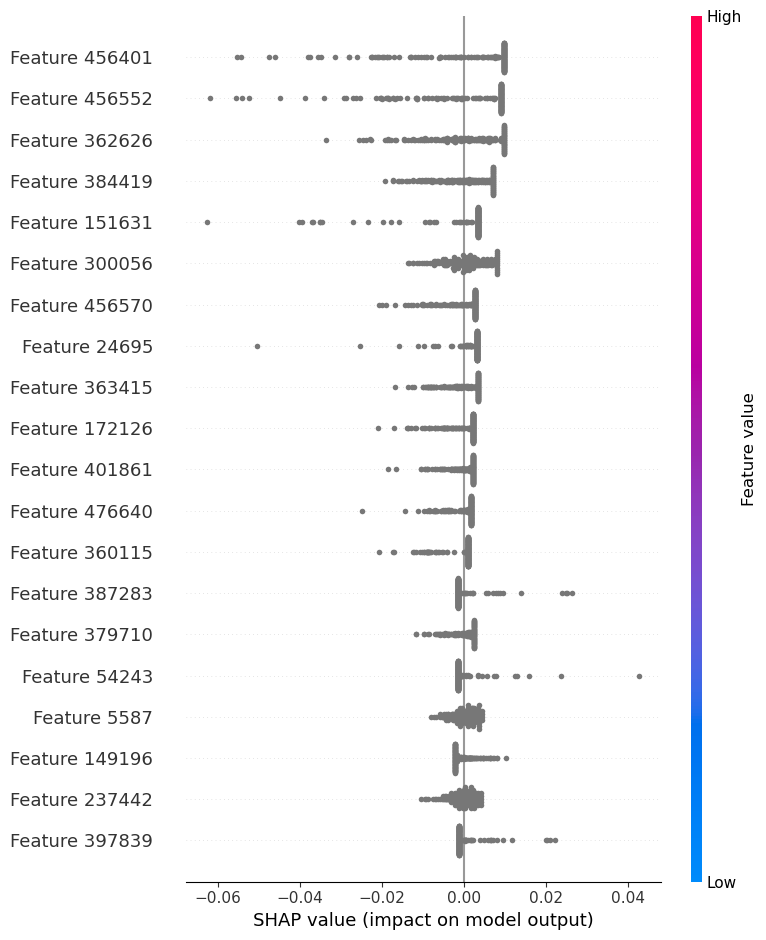

AssertionError: visualize() can only display Explanation objects (or arrays of them)!

In [ ]:
explainer = shap.Explainer(logreg, train_vec)
shap_values = explainer(train_vec)
shap.summary_plot(shap_values, train_vec)
shap.force_plot(explainer.expected_value, shap_values[0, :], train_vec[0, :])


In [94]:
X_train, y_train =( train_vec, train_df['CREATININE'])

In [92]:
from sklearn.model_selection import cross_validate
logreg = LogisticRegression()
scores = cross_validate(logreg, X_train, y_train, cv=10, scoring=['precision','recall','f1_macro','accuracy'])

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1954, in precision_score
    p, _, _, _ = precision_recall_fscore_support(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1573, in precision_recall_fscore_support
    labels = _check_set_wise_labels(y_true, y_pred, average, labels, pos_label)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1382, in _check_set_wise_labels
    raise ValueError(
Val

In [93]:
print(scores)
for s in scores:
  print("%0.2f  with a standard deviation of %0.2f" % (scores[s].mean(), scores[s].std()))

{'fit_time': array([2.22074795, 3.0588851 , 2.92468143, 2.22395563, 2.05942678,
       3.0658164 , 4.57979965, 2.90994215, 2.03796291, 2.3026278 ]), 'score_time': array([0.00797009, 0.01129246, 0.01069832, 0.01514959, 0.02222681,
       0.00733685, 0.01339173, 0.01579905, 0.00750732, 0.01502705]), 'test_precision': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]), 'test_recall': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]), 'test_f1_macro': array([0.36363636, 0.36363636, 0.375     , 0.375     , 0.375     ,
       0.375     , 0.375     , 0.375     , 0.375     , 0.375     ]), 'test_accuracy': array([0.57142857, 0.57142857, 0.6       , 0.6       , 0.6       ,
       0.6       , 0.6       , 0.6       , 0.6       , 0.6       ])}
2.74  with a standard deviation of 0.73
0.01  with a standard deviation of 0.00
nan  with a standard deviation of nan
nan  with a standard deviation of nan
0.37  with a standard deviation of 0.00
0.59  with a standard deviation of 0.01


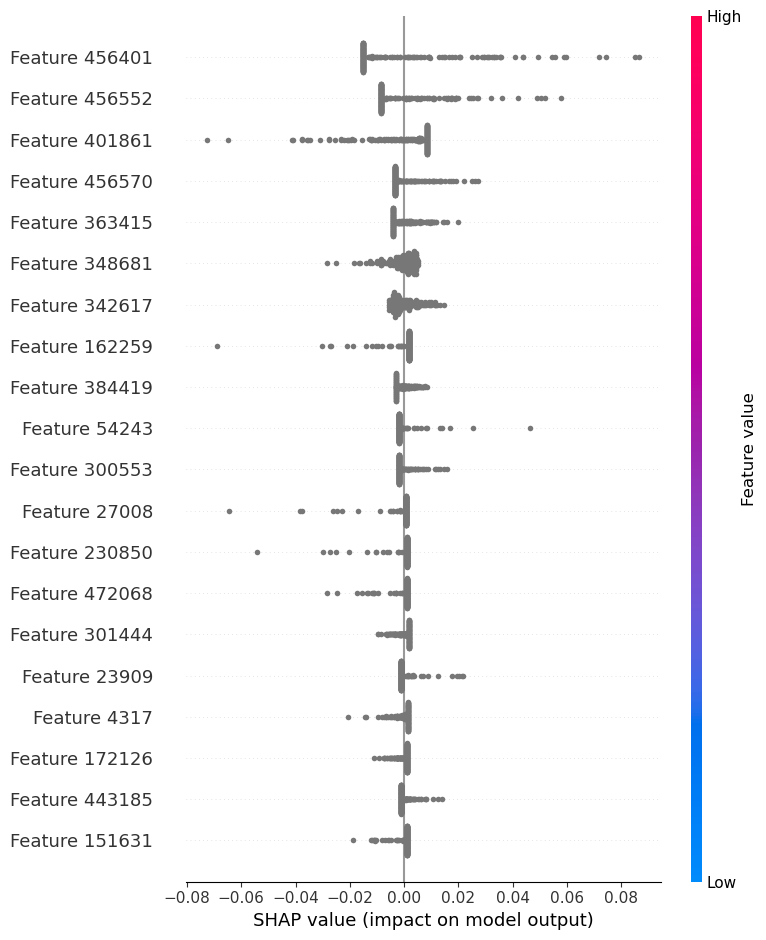

AssertionError: visualize() can only display Explanation objects (or arrays of them)!

In [ ]:
explainer = shap.Explainer(logreg, train_vec)
shap_values = explainer(train_vec)
shap.summary_plot(shap_values, train_vec)
shap.force_plot(explainer.expected_value, shap_values[0, :], train_vec[0, :])


In [95]:
X_train, y_train =( train_vec, train_df['MAJOR-DIABETES'])

In [96]:
from sklearn.model_selection import cross_validate
logreg = LogisticRegression()
scores = cross_validate(logreg, X_train, y_train, cv=10, scoring=['precision','recall','f1_macro','accuracy'])

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1954, in precision_score
    p, _, _, _ = precision_recall_fscore_support(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1573, in precision_recall_fscore_support
    labels = _check_set_wise_labels(y_true, y_pred, average, labels, pos_label)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1382, in _check_set_wise_labels
    raise ValueError(
Val

In [97]:
print(scores)
for s in scores:
  print("%0.2f  with a standard deviation of %0.2f" % (scores[s].mean(), scores[s].std()))

{'fit_time': array([5.63225532, 2.9072113 , 2.50124454, 1.98746347, 3.64519525,
       2.45454526, 2.39428806, 2.27180195, 2.74404693, 3.23868299]), 'score_time': array([0.02163696, 0.0151751 , 0.00743222, 0.01450324, 0.00943804,
       0.00746441, 0.01890182, 0.01044154, 0.01272178, 0.01384473]), 'test_precision': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]), 'test_recall': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]), 'test_f1_macro': array([0.36363636, 0.36363636, 0.35483871, 0.35483871, 0.35483871,
       0.35483871, 0.35483871, 0.35483871, 0.35483871, 0.375     ]), 'test_accuracy': array([0.57142857, 0.57142857, 0.55      , 0.55      , 0.55      ,
       0.55      , 0.55      , 0.55      , 0.55      , 0.6       ])}
2.98  with a standard deviation of 1.00
0.01  with a standard deviation of 0.00
nan  with a standard deviation of nan
nan  with a standard deviation of nan
0.36  with a standard deviation of 0.01
0.56  with a standard deviation of 0.02


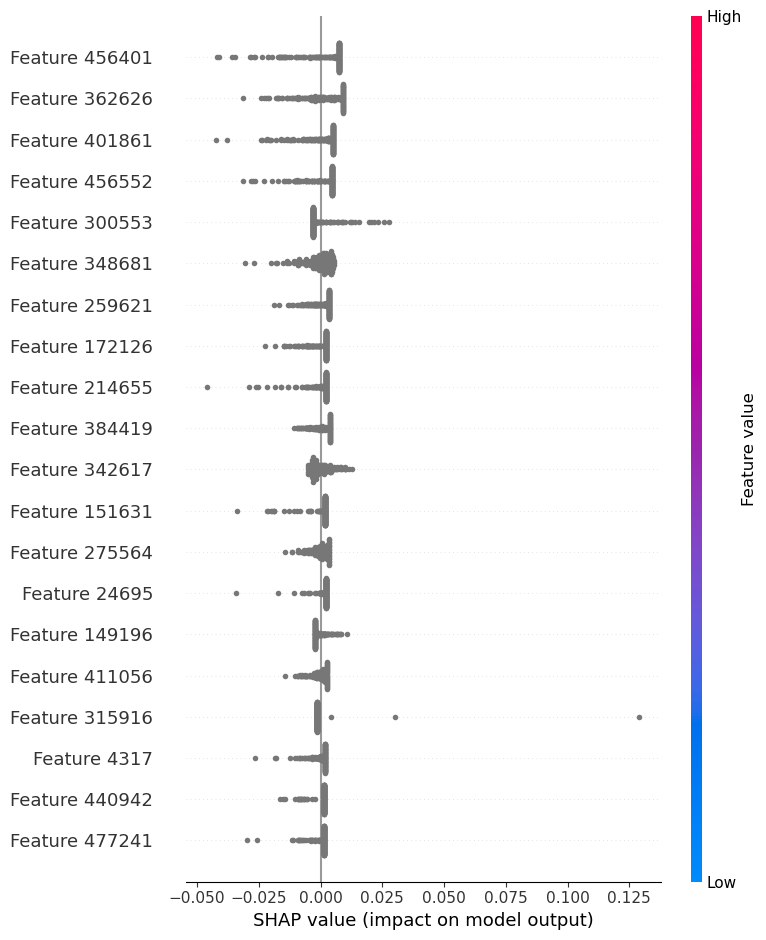

AssertionError: visualize() can only display Explanation objects (or arrays of them)!

In [ ]:
explainer = shap.Explainer(logreg, train_vec)
shap_values = explainer(train_vec)
shap.summary_plot(shap_values, train_vec)
shap.force_plot(explainer.expected_value, shap_values[0, :], train_vec[0, :])


# other

In [ ]:
ADVANCED_CAD_Y_train = train_df['ADVANCED-CAD']
logreg = LogisticRegression()
logreg.fit(train_vec, ADVANCED_CAD_Y_train)
acc_log = round(logreg.score(train_vec, ADVANCED_CAD_Y_train) * 100, 2)
acc_log

88.61

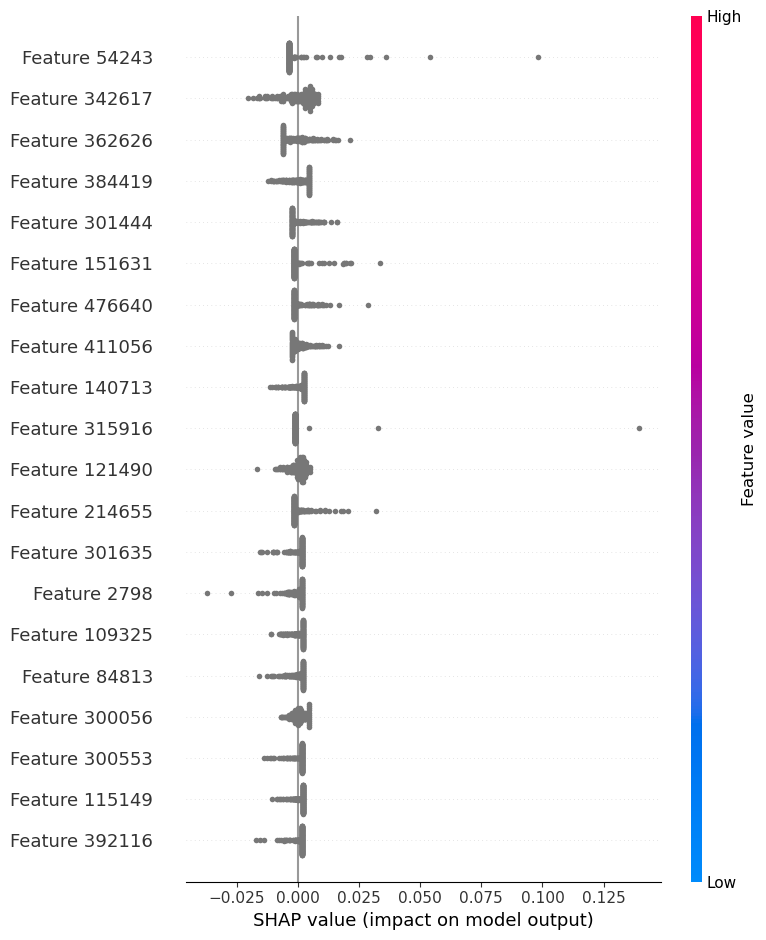

AssertionError: visualize() can only display Explanation objects (or arrays of them)!

In [ ]:
explainer = shap.Explainer(logreg, train_vec)
shap_values = explainer(train_vec)
shap.summary_plot(shap_values, train_vec)
shap.force_plot(explainer.expected_value, shap_values[0, :], train_vec[0, :])


In [ ]:
ALCOHOL_ABUSE_Y_train = train_df['ALCOHOL-ABUSE']
logreg = LogisticRegression()
logreg.fit(train_vec, ALCOHOL_ABUSE_Y_train)
acc_log = round(logreg.score(train_vec, ALCOHOL_ABUSE_Y_train) * 100, 2)
acc_log

96.53

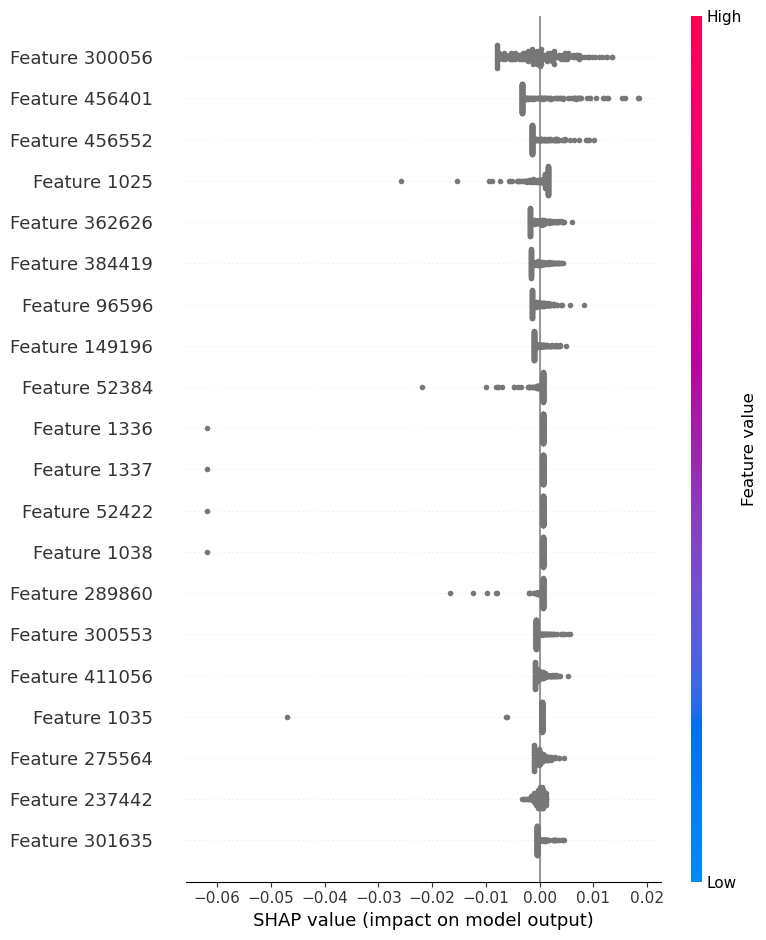

AssertionError: visualize() can only display Explanation objects (or arrays of them)!

In [ ]:
explainer = shap.Explainer(logreg, train_vec)
shap_values = explainer(train_vec)
shap.summary_plot(shap_values, train_vec)
shap.force_plot(explainer.expected_value, shap_values[0, :], train_vec[0, :])


In [ ]:
ASP_Y_train = train_df['ASP-FOR-MI']
logreg = LogisticRegression()
logreg.fit(train_vec, ASP_Y_train)
acc_log = round(logreg.score(train_vec, ASP_Y_train) * 100, 2)
acc_log

80.2

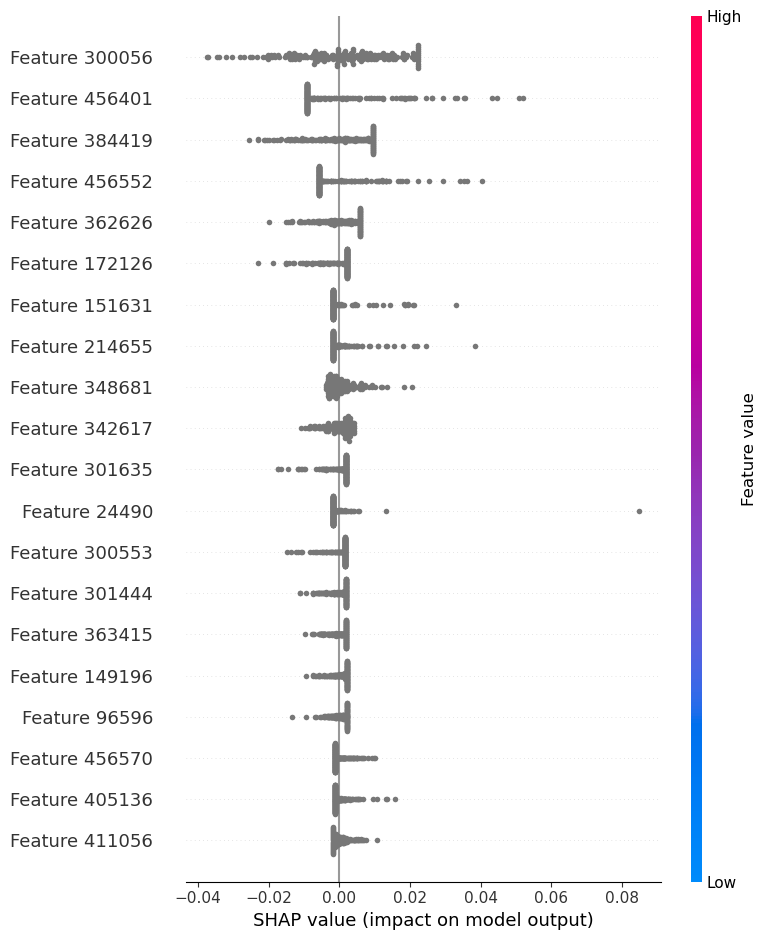

AssertionError: visualize() can only display Explanation objects (or arrays of them)!

In [ ]:
explainer = shap.Explainer(logreg, train_vec)
shap_values = explainer(train_vec)
shap.summary_plot(shap_values, train_vec)
shap.force_plot(explainer.expected_value, shap_values[0, :], train_vec[0, :])


In [ ]:
DIETSUPP_Y_train = train_df['DIETSUPP-2MOS']
logreg = LogisticRegression()
logreg.fit(train_vec, DIETSUPP_Y_train)
acc_log = round(logreg.score(train_vec, DIETSUPP_Y_train) * 100, 2)
acc_log

99.5

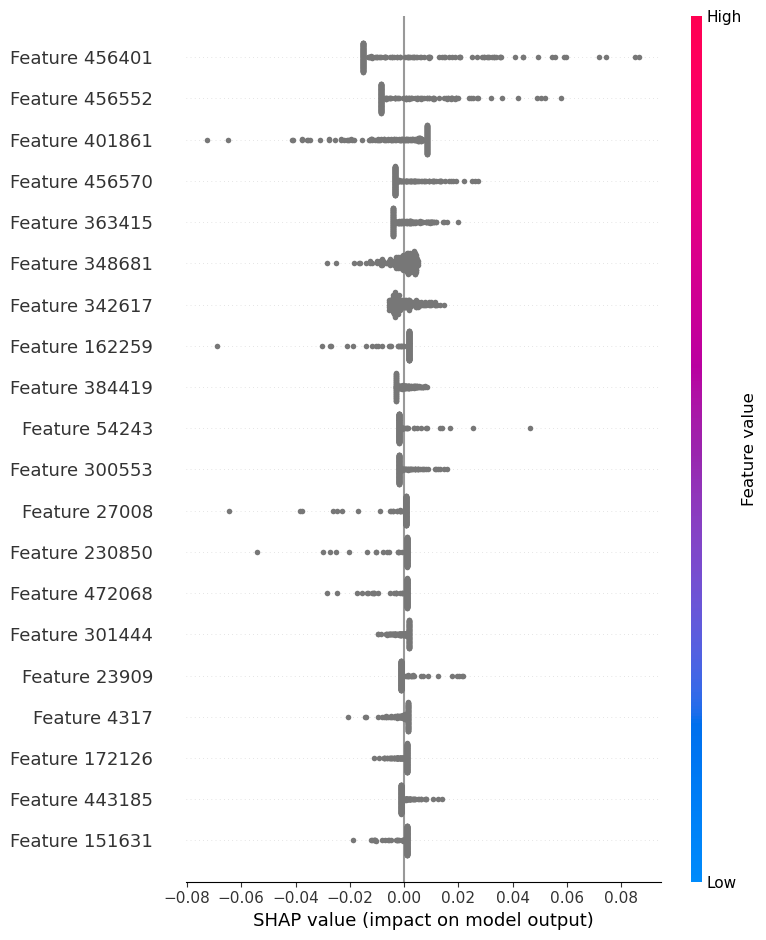

AssertionError: visualize() can only display Explanation objects (or arrays of them)!

In [ ]:
explainer = shap.Explainer(logreg, train_vec)
shap_values = explainer(train_vec)
shap.summary_plot(shap_values, train_vec)
shap.force_plot(explainer.expected_value, shap_values[0, :], train_vec[0, :])


In [ ]:
DRUG_Y_train = train_df['DRUG-ABUSE']
logreg = LogisticRegression()
logreg.fit(train_vec, DRUG_Y_train)
acc_log = round(logreg.score(train_vec, DRUG_Y_train) * 100, 2)
acc_log

94.06

In [ ]:
explainer = shap.Explainer(logreg, train_vec)
shap_values = explainer(train_vec)
shap.summary_plot(shap_values, train_vec)
shap.force_plot(explainer.expected_value, shap_values[0, :], train_vec[0, :])


In [ ]:
ENGLISH_Y_train = train_df['ENGLISH']
logreg = LogisticRegression()
logreg.fit(train_vec, ENGLISH_Y_train)
acc_log = round(logreg.score(train_vec, ENGLISH_Y_train) * 100, 2)
acc_log

95.05

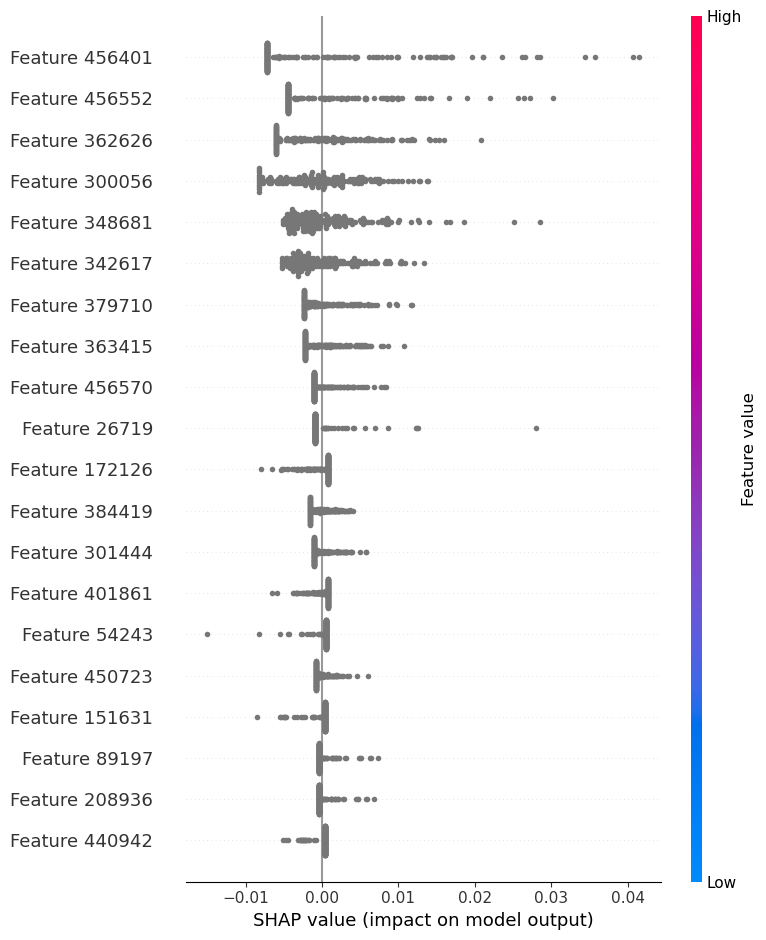

AssertionError: visualize() can only display Explanation objects (or arrays of them)!

In [ ]:
explainer = shap.Explainer(logreg, train_vec)
shap_values = explainer(train_vec)
shap.summary_plot(shap_values, train_vec)
shap.force_plot(explainer.expected_value, shap_values[0, :], train_vec[0, :])


In [ ]:
HBA1C_Y_train = train_df['HBA1C']
logreg = LogisticRegression()
logreg.fit(train_vec, HBA1C_Y_train)
acc_log = round(logreg.score(train_vec, HBA1C_Y_train) * 100, 2)
acc_log

67.82

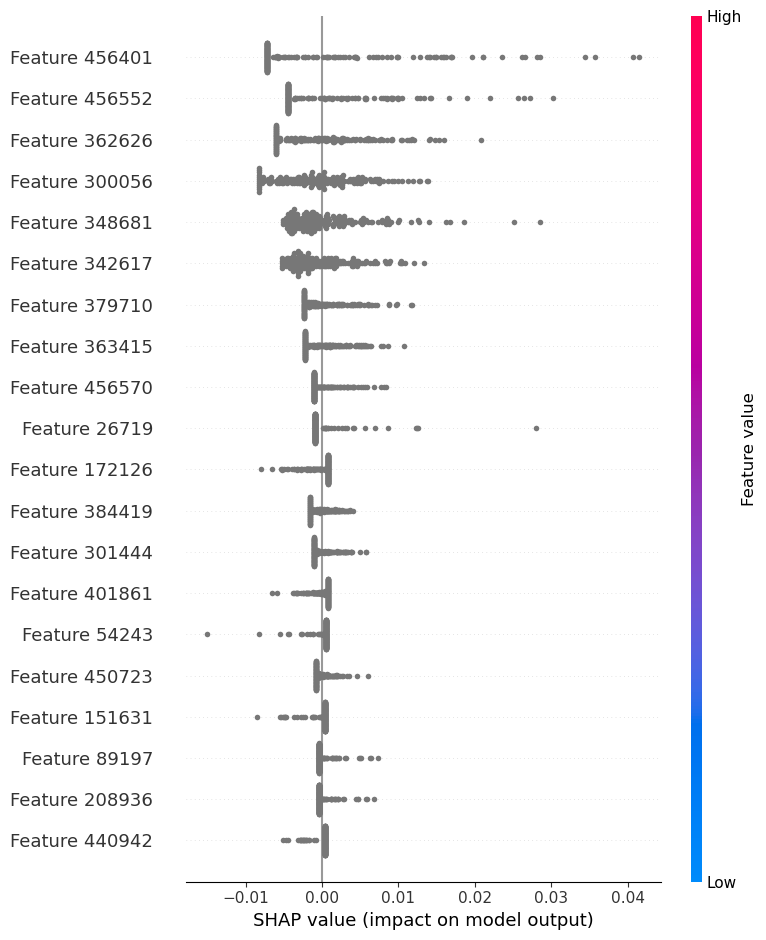

AssertionError: visualize() can only display Explanation objects (or arrays of them)!

In [ ]:
explainer = shap.Explainer(logreg, train_vec)
shap_values = explainer(train_vec)
shap.summary_plot(shap_values, train_vec)
shap.force_plot(explainer.expected_value, shap_values[0, :], train_vec[0, :])


In [ ]:
KETO_Y_train = train_df['KETO-1YR']
logreg = LogisticRegression()
logreg.fit(train_vec, KETO_Y_train)
acc_log = round(logreg.score(train_vec, KETO_Y_train) * 100, 2)
acc_log

99.5

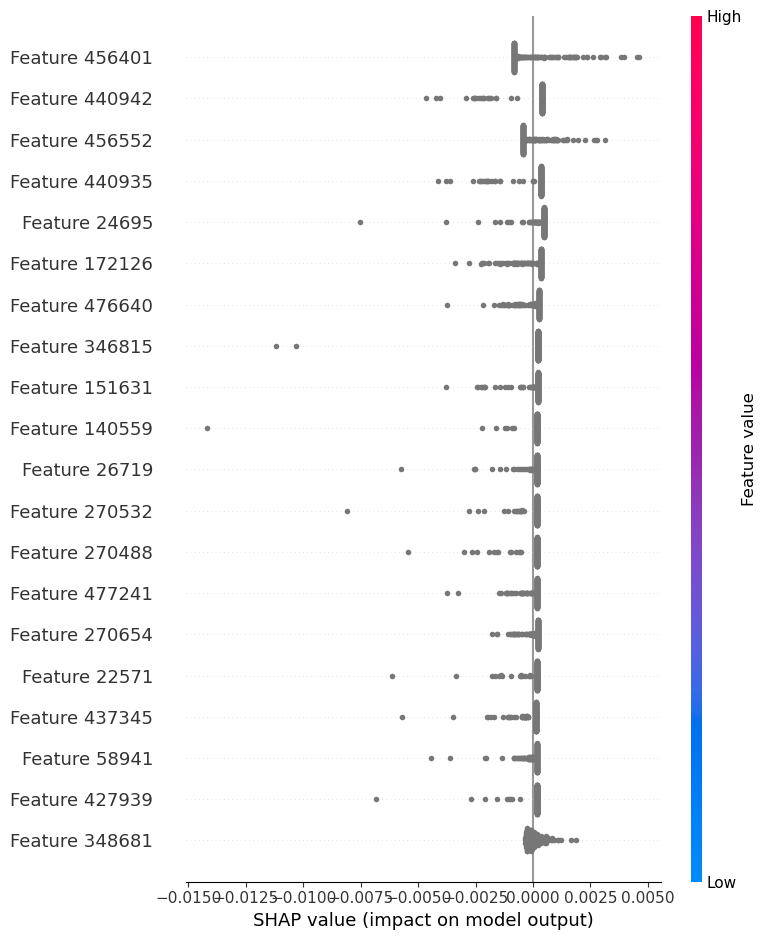

AssertionError: visualize() can only display Explanation objects (or arrays of them)!

In [ ]:
explainer = shap.Explainer(logreg, train_vec)
shap_values = explainer(train_vec)
shap.summary_plot(shap_values, train_vec)
shap.force_plot(explainer.expected_value, shap_values[0, :], train_vec[0, :])


In [ ]:
MAKES_Y_train = train_df['MAKES-DECISIONS']
logreg = LogisticRegression()
logreg.fit(train_vec, MAKES_Y_train)
acc_log = round(logreg.score(train_vec, MAKES_Y_train) * 100, 2)
acc_log

96.04

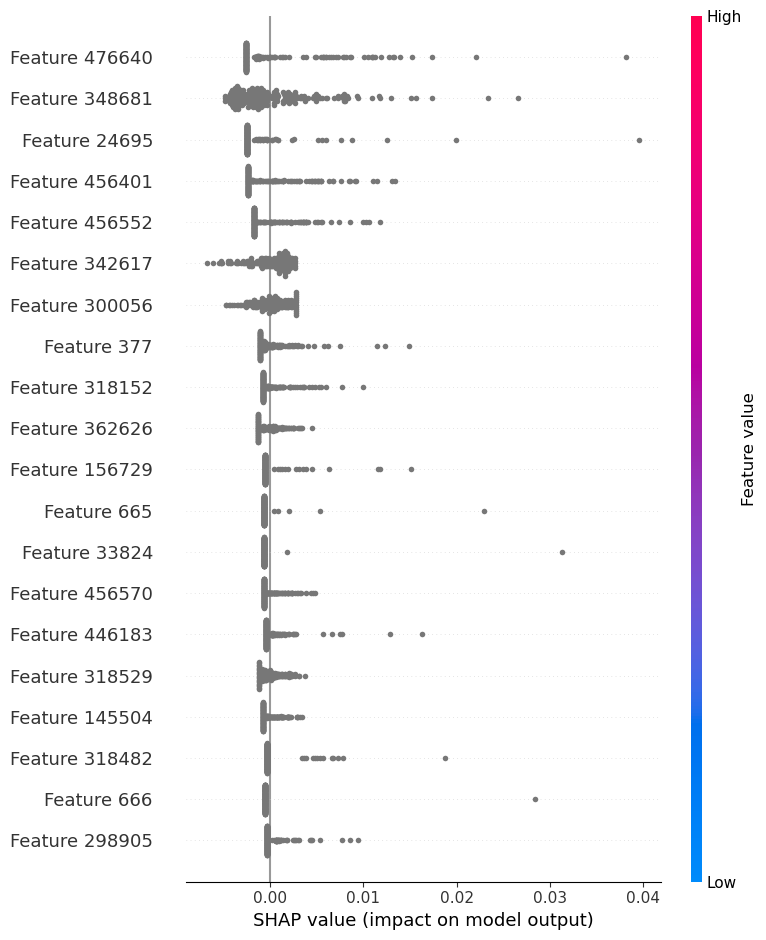

AssertionError: visualize() can only display Explanation objects (or arrays of them)!

In [ ]:
explainer = shap.Explainer(logreg, train_vec)
shap_values = explainer(train_vec)
shap.summary_plot(shap_values, train_vec)
shap.force_plot(explainer.expected_value, shap_values[0, :], train_vec[0, :])


In [ ]:
MI_Y_train = train_df['MI-6MOS']
logreg = LogisticRegression()
logreg.fit(train_vec, MI_Y_train)
acc_log = round(logreg.score(train_vec, MI_Y_train) * 100, 2)
acc_log

91.09

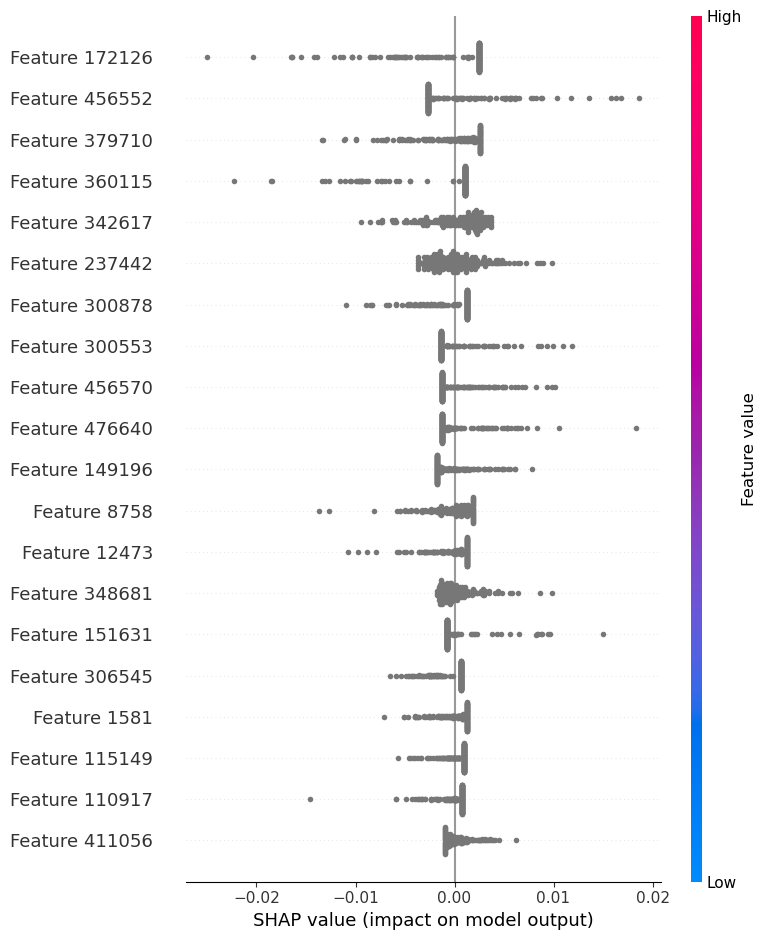

AssertionError: visualize() can only display Explanation objects (or arrays of them)!

In [ ]:
explainer = shap.Explainer(logreg, train_vec)
shap_values = explainer(train_vec)
shap.summary_plot(shap_values, train_vec)
shap.force_plot(explainer.expected_value, shap_values[0, :], train_vec[0, :])
